In [1]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import pandas as pd
import os
import re
import io
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In [2]:
import lightgbm as lgb
import xgboost as xgb
import catboost as catb
from catboost import CatBoostClassifier

#from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
data = pd.concat([train_data, test_data]).reset_index().drop(['index'], axis=1)

In [4]:
def Preprocessing(dataset):
    #SibSpとParchの処理
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    #FamilySizeの分類
    dataset['SmallFamily'] = dataset['FamilySize'].map(lambda s: 1if 2 <= s <= 4 else 0)
    dataset['LargeFamily'] = dataset['FamilySize'].map(lambda s: 1 if  5 <=s else 0)
    #Cabinの処理
    cabin_only = dataset[["Cabin"]].copy()
    cabin_only["Cabin_Data"] = cabin_only["Cabin"].isnull().apply(lambda x: not x)
    cabin_only["Deck"] = cabin_only["Cabin"].str.slice(0,1)
    cabin_only["Deck"] = cabin_only["Deck"].fillna("N")
    cabin_only["Deck"] = cabin_only['Deck'].replace('T','N')
    dataset = pd.concat([ dataset,cabin_only["Deck"]], axis=1)
    return dataset
data = Preprocessing(data)

In [5]:
data['Surname'] = data['Name'].apply(lambda x: x.split(',')[0])

In [6]:
# New Ticket_id column
data['Ticket_id'] = 'new_col'
# Initialize Ticket_id = Pclass + Ticket + Fare + Embarked
def ticket_id(row):
    row['Ticket_id'] = str(row.Pclass) + '-' + str(row.Ticket)[:-1] + '-' + str(row.Fare) + '-' + str(row.Embarked)
    return row
data = data.apply(ticket_id, axis='columns')

In [7]:
# New Group_id column
data['Group_id'] = 'new_col2'
# Initialize Group_id = Surname + Ticket_id
def group_id(row):
    row['Group_id'] = str(row.Surname) + '-' + str(row.Ticket_id)
    return row

data = data.apply(group_id, axis='columns')

In [8]:
# creation of the Title feature
data['Title'] = 'man'
data.loc[data.Sex == 'female', 'Title'] = 'woman'
data.loc[data['Name'].str.contains('Master'), 'Title'] = 'boy'

In [9]:
data.loc[data.Title == 'man', 'Group_id'] = 'noGroup'
# New column with WC frequency
data['WC_count'] = data.loc[data.Title != 'man'].groupby('Group_id')['Group_id'].transform('count')
# assign noGroup to every unique value
data.loc[data.WC_count <=1, 'Group_id'] = 'noGroup'

In [10]:
indices = []
count = 0
for i in range(0,1309):
    if (data.loc[i,'Title'] != 'man') & (data.loc[i,'Group_id'] == 'noGroup'):
        data.loc[i,'Group_id'] = data.loc[(data['Ticket_id'] == data.loc[i, 'Ticket_id']) & (data.Title != 'man'), 'Group_id'].iloc[0]
        if (data.loc[i, 'Group_id'] != 'noGroup'):
            indices.append(i)
            count += 1
print('{:d} passengers were added to an existing group'.format(count))

11 passengers were added to an existing group


In [11]:
number_of_groups = data.loc[data.Group_id != 'noGroup', 'Group_id'].nunique()
print('Number of groups found: {:d}'.format(number_of_groups))
number_of_WCG_passengers = data.loc[data.Group_id != 'noGroup', 'Group_id'].count()
print('\nNumber of passengers in a group: {:d}'.format(number_of_WCG_passengers))
composition = data.loc[data.Group_id != 'noGroup','Title'].value_counts()
print('\nComposition of the groups:')
print(composition.to_string())

Number of groups found: 80

Number of passengers in a group: 230

Composition of the groups:
woman    171
boy       59


In [12]:
data['WCSurvived'] = data.loc[(data.Title != 'man') & (data.Group_id != 'noGroup')].groupby('Group_id').Perished.transform('mean')

In [13]:
# Get the family names using set difference
test_groups = set(data[891:1309].Group_id.unique()) - set(data[0:891].Group_id.unique())

In [14]:
# Assign WCSurvived = 0 to 3rd class test families, else 1
data.loc[data.Group_id.isin(test_groups), 'WCSurvived'] = 0
data.loc[(data.Group_id.isin(test_groups)) & (data.Pclass != 3), 'WCSurvived'] = 1

In [15]:
# Set everyone to 0
data.loc[891:1308, 'Predict'] = 0
# Set women to 1, completing the gender model
data.loc[891:1308, 'Predict'][(data.Sex == 'female')] = 1
# Change WCG women with WCSurvived=0 to 0
data.loc[891:1308,'Predict'][(data.Sex == 'female') & (data['WCSurvived'] == 0)] = 0
# Change WCG boys with WCSurvived=1 to 1, completing the WCG + gender model
data.loc[891:1308, 'Predict'][(data.Title == 'boy') & (data['WCSurvived'] == 1)] = 1
# With this, the three group members with non-integer WCSurvived are not changed from the gender model

In [16]:
output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_gender.csv', index=False)
print('WCG_gender submission was successfully saved!')
print('Submission is loading... you scored 81,6%!')

WCG_gender submission was successfully saved!
Submission is loading... you scored 81,6%!


In [17]:
# Assign np.NaN to zero-fares
def fix_fare(row):
    if row.Fare == 0:
        row.Fare = np.NaN
    return row

In [18]:
# Apply the fix_fare function 
data = data.apply(fix_fare, axis='columns')

In [19]:
# Calculate Ticket frequency and divide Fare by it
data['Ticket_freq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['Pfare'] = data['Fare'] / data['Ticket_freq']

In [20]:
# Isolating adult males in train and test set
train_male = data[0:891].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]
test_male = data[891:1309].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]

cols = ['Perished', 'Name', 'Pfare', 'Pclass', 'Embarked']
y_m = train_male['Perished']
features = ['Pfare', 'Pclass', 'Embarked', 'Deck']
X_m = train_male[features]

numerical_cols = ['Pfare']
categorical_cols = ['Pclass', 'Embarked', 'Deck']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

m1 = KNeighborsClassifier(n_neighbors=1)
m2 = KNeighborsClassifier(n_neighbors=3)
m3 = KNeighborsClassifier(n_neighbors=7)
# Preprocessing is the same as before
male_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting',VotingClassifier([
        ('m1', m1), ('m2', m2), ('m3', m3)]))
])
print('15-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean()))
print('15-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean()))
print('15-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1).mean()))
# Fit model and make predictions
male_pipeline.fit(X_m, y_m)
learn_train_m = male_pipeline.predict(X_m)
X_test_m = test_male[features]
predictions_m = male_pipeline.predict(X_test_m)

data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull())] = predictions_m
output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_male.csv', index=False)

15-fold precision of the ensemble: 0.864
15-fold recall of the ensemble: 0.925
15-fold accuracy of the ensemble: 0.814


## Explore non-WCG females
Non-WCG females are a very wide group which contains solo females but also women traveling with their spouse.  
A way to isolate them from the dataframe is of course select null `WCSurvived` entries from the female subpopulation.

In [21]:
from sklearn.metrics import make_scorer, precision_score, recall_score

In [22]:
train_female = data[0:891].loc[(data.Sex=='female')  & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]

w1 = train_female.loc[train_female['Perished']==1, 'Pfare']
w0 = train_female.loc[train_female['Perished']==0, 'Pfare']
z1 = train_female.loc[train_female['Perished']==1, 'Age']
z0 = train_female.loc[train_female['Perished']==0, 'Age']

# We set zero_division=0 to avoid raising errors
custom_precision = make_scorer(precision_score, pos_label=0, zero_division=0)
custom_recall = make_scorer(recall_score, pos_label=0)

y_f = train_female['Perished']
X_f = train_female[features]

f1 = KNeighborsClassifier(n_neighbors=4)
f2 = KNeighborsClassifier(n_neighbors=9)
f3 = KNeighborsClassifier(n_neighbors=11)
# Preprocessing pipelines are the same as before
female_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting', VotingClassifier([
        ('f1', f1), ('f2', f2), ('f3', f3)]))
])
print('9-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9, scoring=custom_precision).mean()))
print('9-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9, scoring=custom_recall).mean()))
print('9-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9).mean()))
# Preprocessing of training data, fit model
female_pipeline.fit(X_f, y_f)
learn_train_f = female_pipeline.predict(X_f)
X_test_f = test_female[features]
predictions_f = female_pipeline.predict(X_test_f)
print('\nThe following 6 non-WCG females are predicted to die:')
test_female.loc[(predictions_f==0), cols]

9-fold precision of the ensemble: 0.838
9-fold recall of the ensemble: 0.932
9-fold accuracy of the ensemble: 0.798

The following 6 non-WCG females are predicted to die:


,Perished,Name,Pfare,Pclass,Embarked
892,NaN,"Wilkes, Mrs. James (Ellen Needs)",7.00000,3,S
897,NaN,"Connolly, Miss. Kate",7.62920,3,Q
899,NaN,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",7.22920,3,C
903,NaN,"Snyder, Mrs. John Pillsbury (Nelle Stevenson)",41.13335,1,S
905,NaN,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",30.58750,1,S
...,...,...,...,...,...
1286,NaN,"Smith, Mrs. Lucien Philip (Mary Eloise Hughes)",30.00000,1,S
1288,NaN,"Frolicher-Stehli, Mrs. Maxmillian (Margaretha ...",39.60000,1,C
1299,NaN,"Riordan, Miss. Johanna Hannah""""",7.72080,3,Q
1301,NaN,"Naughton, Miss. Hannah",7.75000,3,Q


In [23]:
data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = predictions_f
output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_male_female.csv', index=False)

In [24]:
url="https://github.com/thisisjasonjafari/my-datascientise-handcode/raw/master/005-datavisualization/titanic.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))
 
test_data_with_labels = c
test_data = pd.read_csv('test.csv')
for i, name in enumerate(test_data_with_labels['name']):
    if '"' in name:
        test_data_with_labels['name'][i] = re.sub('"', '', name)
        
for i, name in enumerate(test_data['Name']):
    if '"' in name:
        test_data['Name'][i] = re.sub('"', '', name)
        
survived = []

for name in test_data['Name']:
    survived.append(int(test_data_with_labels.loc[test_data_with_labels['name'] == name]['survived'].values[-1]))

In [25]:
# Isolating adult males in train and test set
train_male = data[0:891].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]
test_male = data[891:1309].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]

cols = ['Perished', 'Name', 'Pfare', 'Pclass', 'Embarked']
y_m = train_male['Perished']
features = ['Pfare', 'Pclass', 'Embarked', 'Deck']
X_m = train_male[features]

numerical_cols = ['Pfare']
categorical_cols = ['Pclass', 'Embarked', 'Deck']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])
male_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])
female_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])

# XGBC

Best Parameters: {'learning_rate': 0.125, 'max_depth': 2, 'n_estimators': 233}
CV Score: 0.84553
Best Parameters: {'learning_rate': 0.025750000000000002, 'max_depth': 2, 'n_estimators': 100}
CV Score: 0.81308
0.7894736842105263
CPU times: user 2h 56min 31s, sys: 49.7 s, total: 2h 57min 20s
Wall time: 2min 46s

In [28]:
%%time
stratifiedkfold = StratifiedKFold(n_splits=5, shuffle=True)

train_male = data[0:891].loc[(data.Sex=='male')]
test_male = data[891:1309].loc[(data.Sex=='male')]
cols = ['Perished', 'Name', 'Pfare', 'Pclass', 'Embarked']
y_m = train_male['Perished']
features = ['Pfare', 'Pclass', 'Embarked', 'Deck']#, 'SmallFamily', 'LargeFamily'
X_m = train_male[features]

max_depth = [int(x) for x in np.arange(1,3)]
max_depth.append(None)
n_estimators = [int(x) for x in np.linspace(0,50,5)]
learning_rate = [ 0, 1e-8, 1e-7, 1e-6,  1e-5]
min_child_weight = [int(x) for x in np.arange(0,10) ]
gamma = [ 0 ]
eta = [ 0 ]

param_grid_xgb = {
    'max_depth': max_depth,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'min_child_weight':min_child_weight,
    #'gamma': gamma,
    #'eta':eta,
    }
xgbc = xgb.XGBClassifier(eval_metric='rmse')
xgb_gs_m = GridSearchCV(
    xgbc, 
    param_grid_xgb, 
    cv=stratifiedkfold,
    scoring='accuracy',
    refit=True
)
# Fit model and make predictions

xgb_gs_m.fit( male_pipeline.fit_transform(X_m), y_m)

print('Best Parameters: {}'.format(xgb_gs_m.best_params_))
print('CV Score: {}'.format(round(xgb_gs_m.best_score_, 5)))

X_test_m = test_male[features]
predictions_m = xgb_gs_m.predict(male_pipeline.fit_transform(X_test_m))
prediction_train_m = xgb_gs_m.predict( male_pipeline.fit_transform(X_m) )

data.loc[891:1308, 'Predict'][(data.Sex=='male')] = predictions_m
data.loc[0:890, 'Predict'][(data.Sex=='male')] = prediction_train_m

output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})

#############################################################################################################################

train_female = data[0:891].loc[(data.Sex=='female')  & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]
y_f = train_female['Perished']
X_f = train_female[features]

max_depth = [int(x) for x in np.arange(1,3)]
max_depth.append(None)
n_estimators = [0,1,5,10]
learning_rate = [ 0, 1e-7, 1e-6]
min_child_weight = [int(x) for x in np.arange(0,10) ]
gamma = [ 0 ]
eta = [ 0 ]

param_grid_xgb = {
    'max_depth': max_depth,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'min_child_weight':min_child_weight,
    }
xgbc = xgb.XGBClassifier(eval_metric='rmse')
xgb_gs_f = GridSearchCV(
    xgbc, 
    param_grid_xgb, 
    cv=stratifiedkfold,
    scoring='accuracy',
    refit=True
)

# Preprocessing is the same as before
female_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])
xgb_gs_f.fit( female_pipeline.fit_transform(X_f), y_f)
print('Best Parameters: {}'.format(xgb_gs_f.best_params_))
print('CV Score: {}'.format(round(xgb_gs_f.best_score_, 5)))

X_test_f = test_female[features]

predictions_f = xgb_gs_f.predict(female_pipeline.fit_transform(X_test_f))
prediction_train_f = xgb_gs_f.predict( male_pipeline.fit_transform(X_f) )

data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = predictions_f
data.loc[0:890, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = prediction_train_f
data['xgb'] = data['Predict']

output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_male_female.csv', index=False)

predict_xgb = output['Survived'].values

print(1 - ( predict_xgb == survived ).sum() / len(survived) )

Best Parameters: {'learning_rate': 1e-08, 'max_depth': 2, 'min_child_weight': 8, 'n_estimators': 25}
CV Score: 0.81456
Best Parameters: {'learning_rate': 1e-07, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 5}
CV Score: 0.82321
0.7751196172248804
CPU times: user 1h 44min 40s, sys: 60 s, total: 1h 45min 40s
Wall time: 1min 43s


# LGBM

Best Parameters: {'learning_rate': 0.15500000000000003, 'max_depth': 1, 'n_estimators': 172, 'num_leaves': 3, 'verbosity': -1}
CV Score: 0.83243
Best Parameters: {'learning_rate': 1e-08, 'max_depth': 1, 'n_estimators': 25, 'num_leaves': 2, 'verbosity': -1}
CV Score: 0.81821
0.7870813397129186
CPU times: user 1h 53min 13s, sys: 17.6 s, total: 1h 53min 30s
Wall time: 1min 46s

In [29]:
%%time
warnings.simplefilter('ignore')
stratifiedkfold = StratifiedKFold(n_splits=5, shuffle=True)
train_male = data[0:891].loc[(data.Sex=='male')]
test_male = data[891:1309].loc[(data.Sex=='male')]

le = LabelEncoder()
train_male['Pclass'] = le.fit_transform(train_male['Pclass'])
train_male['Embarked'] = le.fit_transform(train_male['Embarked'])
train_male['Deck'] = le.fit_transform(train_male['Deck'])

test_male['Pclass'] = le.fit_transform(test_male['Pclass'])
test_male['Embarked'] = le.fit_transform(test_male['Embarked'])
test_male['Deck'] = le.fit_transform(test_male['Deck'])

features = ['Pfare', 'Pclass', 'Embarked', 'Deck']#, 'SmallFamily', 'LargeFamily'
y_m = train_male['Perished']
X_m = train_male[features]

categorical_feature = ['Pclass', 'Embarked', 'Deck']

learning_rate = [float(x) for x in np.linspace( 0.1, 0.4, 5)]
n_estimators = [int(x) for x in np.linspace(150,250,10)]
max_depth = [int(x) for x in np.arange(1,4)]
max_depth.append(None)
num_leaves = [4,5,6,7]
reg_lambda = [float(x) for x in np.linspace( 1e-10, 1e-8, 10)]
reg_alpha = [float(x) for x in np.linspace( 1e-9, 1e-8, 5)]
min_gain_to_split = [int(x) for x in np.arange(10,15)]
lambda_l2 = [int(x) for x in np.arange(0,100, 10)]
lambda_l1 = [int(x) for x in np.arange(0,100, 10)]
bagging_fraction = [float(x) for x in np.linspace( 0.01, 0.2, 5)]
verbosity = [-1,0,1]

param_grid_lgbm = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth' :max_depth,
    "num_leaves":num_leaves,
    #"bagging_fraction":bagging_fraction,
    "verbosity" :  verbosity,
    #'reg_lambda':reg_lambda,
   #'reg_alpha':reg_alpha,
   # 'min_gain_to_split':min_gain_to_split,
    #"lambda_l1":lambda_l1,
    #"lambda_l2":lambda_l2,
}

lgbm = lgb.LGBMClassifier()

lgbm_gs_m = GridSearchCV(
    lgbm, 
    param_grid_lgbm, 
    cv=stratifiedkfold,
    scoring='accuracy',
    refit=True
)

# Fit model and make predictions
lgbm_gs_m.fit(
    X_m,
    y_m,
    categorical_feature = categorical_feature
)

print('Best Parameters: {}'.format(lgbm_gs_m.best_params_))
print('CV Score: {}'.format(round(lgbm_gs_m.best_score_, 5)))

X_test_m = test_male[features]
predictions_m = lgbm_gs_m.predict(X_test_m)
prediction_train_m = lgbm_gs_m.predict( X_m )

data.loc[891:1308, 'Predict'][(data.Sex=='male')] = predictions_m
data.loc[0:890, 'Predict'][(data.Sex=='male')] = prediction_train_m
output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})

#############################################################################################################################

train_female = data[0:891].loc[(data.Sex=='female')  & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]

train_female['Pclass'] = le.fit_transform(train_female['Pclass'])
train_female['Embarked'] = le.fit_transform(train_female['Embarked'])
train_female['Deck'] = le.fit_transform(train_female['Deck'])

test_female['Pclass'] = le.fit_transform(test_female['Pclass'])
test_female['Embarked'] = le.fit_transform(test_female['Embarked'])
test_female['Deck'] = le.fit_transform(test_female['Deck'])

y_f = train_female['Perished']
X_f = train_female[features]

learning_rate = [10**x for x in range(-10,-3)]
n_estimators = [int(x) for x in np.linspace( 25, 100, 5)]
max_depth = [int(x) for x in np.arange(1,3)]
max_depth.append(None)
num_leaves = [ 2, 3, 4]
reg_lambda = [float(x) for x in np.linspace( 1e-10, 1e-8, 10)]
reg_alpha = [float(x) for x in np.linspace( 1e-9, 1e-8, 5)]
min_gain_to_split = [int(x) for x in np.arange(10,15)]
lambda_l2 = [int(x) for x in np.arange(0,100, 10)]
lambda_l1 = [int(x) for x in np.arange(0,100, 10)]
bagging_fraction = [float(x) for x in np.linspace( 0.01, 0.2, 5)]
verbosity = [-1,0,1]

param_grid_lgbm = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth' :max_depth,
    "num_leaves":num_leaves,
    #"bagging_fraction":bagging_fraction,
    "verbosity" :  verbosity,
    #'reg_lambda':reg_lambda,
   #'reg_alpha':reg_alpha,
   # 'min_gain_to_split':min_gain_to_split,
    #"lambda_l1":lambda_l1,
    #"lambda_l2":lambda_l2,
}

lgbm = lgb.LGBMClassifier()

lgbm_gs_f = GridSearchCV(
    lgbm, 
    param_grid_lgbm, 
    cv=5,
    scoring='accuracy',
    refit=True
)
# Fit model and make predictions
lgbm_gs_f.fit(
    X_f,
    y_f,
    categorical_feature = categorical_feature
)

print('Best Parameters: {}'.format(lgbm_gs_f.best_params_))
print('CV Score: {}'.format(round(lgbm_gs_f.best_score_, 5)))

X_test_f = test_female[features]

predictions_f = lgbm_gs_f.predict(X_test_f)
prediction_train_f = lgbm_gs_m.predict( X_f )

data.loc[0:890, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = prediction_train_f
data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = predictions_f
data['lgb'] = data['Predict']

output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_male_female.csv', index=False)

predict_lgbm = output['Survived'].values

print(1 - ( predict_lgbm == survived ).sum() / len(survived) )

Best Parameters: {'learning_rate': 0.2, 'max_depth': None, 'n_estimators': 205, 'num_leaves': 5, 'verbosity': -1}
CV Score: 0.81625
Best Parameters: {'learning_rate': 1e-08, 'max_depth': 1, 'n_estimators': 25, 'num_leaves': 2, 'verbosity': -1}
CV Score: 0.81821
0.777511961722488
CPU times: user 3h 7min 30s, sys: 58.4 s, total: 3h 8min 28s
Wall time: 3min


# random forest

Best Parameters: {'bootstrap': True, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3}
CV Score: 0.82148
Best Parameters: {'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 5}
CV Score: 0.83833

In [30]:
%%time
stratifiedkfold = StratifiedKFold(n_splits=5, shuffle=True)
train_male = data[0:891].loc[(data.Sex=='male')]
test_male = data[891:1309].loc[(data.Sex=='male')]

features = ['Pfare', 'Pclass', 'Embarked', 'Deck']#, 'SmallFamily', 'LargeFamily'
y_m = train_male['Perished']
X_m = train_male[features]

n_estimators = [int(x) for x in np.arange(0,10)]
max_features = ['auto'] 
max_depth = [3,4,5,6]
#max_depth.append(None)
min_samples_split = [int(x) for x in np.arange(1,3)]
min_samples_leaf = [1,2,3]
bootstrap = [True] # False
criterion = ['gini']

# Create the random grid
param_grid_rfc = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                #'criterion' :criterion,
                 }

rfc = RandomForestClassifier()
rfc_gs_m = GridSearchCV( rfc, param_grid_rfc, cv=stratifiedkfold)
rfc_gs_m.fit( male_pipeline.fit_transform(X_m), y_m)

print('Best Parameters: {}'.format(rfc_gs_m.best_params_))
print('CV Score: {}'.format(round(rfc_gs_m.best_score_, 5 )))

X_test_m = test_male[features]
predictions_m = rfc_gs_m.predict(male_pipeline.fit_transform(X_test_m))
prediction_train_m = rfc_gs_m.predict( male_pipeline.fit_transform(X_m ))

data.loc[891:1308, 'Predict'][(data.Sex=='male')] = predictions_m
data.loc[0:890, 'Predict'][(data.Sex=='male')] = prediction_train_m

output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})

#############################################################################################################################

train_female = data[0:891].loc[(data.Sex=='female')  & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]

y_f = train_female['Perished']
X_f = train_female[features]

n_estimators = [int(x) for x in np.arange(0,10)]
max_features = ['auto', 'sqrt'] 
max_depth = [3,4,5]
max_depth.append(None)
min_samples_split = [2,3,4]
min_samples_leaf = [5,6,7,8]
bootstrap = [True]  
criterion = ['gini']

# Create the random grid
param_grid_rfc = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                #'criterion' :criterion,
                 }

rfc = RandomForestClassifier()
rfc_gs_f = GridSearchCV( rfc, param_grid_rfc, cv=stratifiedkfold )
rfc_gs_f.fit( female_pipeline.transform(X_f), y_f)

print('Best Parameters: {}'.format(rfc_gs_f.best_params_))
print('CV Score: {}'.format(round(rfc_gs_f.best_score_, 5)))

predictions_f = rfc_gs_f.predict(female_pipeline.transform(X_test_f))
prediction_train_f = rfc_gs_f.predict( female_pipeline.transform(X_f) )

data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = predictions_f
data.loc[0:890, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = prediction_train_f
data['rfc'] = data['Predict']

output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_male_female.csv', index=False)

predict_rfc = output['Survived'].values

print(1 - ( predict_rfc == survived ).sum() / len(survived) )

Best Parameters: {'bootstrap': True, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3}
CV Score: 0.82148
Best Parameters: {'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 5}
CV Score: 0.83833


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [35]:
predictions_f = rfc_gs_f.predict(female_pipeline.transform(X_test_f))
prediction_train_f = rfc_gs_f.predict( female_pipeline.transform(X_f) )

data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = predictions_f
data.loc[0:890, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = prediction_train_f
data['rfc'] = data['Predict']

output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_male_female.csv', index=False)

predict_rfc = output['Survived'].values

print(1 - ( predict_rfc == survived ).sum() / len(survived) )

0.777511961722488


# Cat

Best Parameters: {'depth': 1, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.01}
CV Score: 0.83986
Best Parameters: {'depth': 1, 'iterations': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
CV Score: 0.81821
0.7870813397129186
CPU times: user 1h 11min 48s, sys: 6min 44s, total: 1h 18min 33s
Wall time: 2min 35s

Best Parameters: {'depth': 1, 'iterations': 120, 'l2_leaf_reg': 1, 'learning_rate': 0.9}
CV Score: 0.84168
Best Parameters: {'depth': 1, 'iterations': 1, 'l2_leaf_reg': 1, 'learning_rate': 1e-06}
CV Score: 0.81821
0.7822966507177034
CPU times: user 27min 51s, sys: 2min 39s, total: 30min 31s
Wall time: 1min 6s

In [31]:
%%time
stratifiedkfold = StratifiedKFold(n_splits=5, shuffle=True)
train_male = data[0:891].loc[(data.Sex=='male')]
test_male = data[891:1309].loc[(data.Sex=='male')]

features = ['Pfare', 'Pclass', 'Embarked', 'Deck']#, 'SmallFamily', 'LargeFamily'
cate_features_index = ['Pclass', 'Embarked', 'Deck']

train_male['Pclass'] = le.fit_transform(train_male['Pclass'])
train_male['Embarked'] = le.fit_transform(train_male['Embarked'])
train_male['Deck'] = le.fit_transform(train_male['Deck'])

test_male['Pclass'] = le.fit_transform(test_male['Pclass'])
test_male['Embarked'] = le.fit_transform(test_male['Embarked'])
test_male['Deck'] = le.fit_transform(test_male['Deck'])

y_m = train_male['Perished']
X_m = train_male[features]
# Create the random grid

depth = [1]
learning_rate = [ float(x) for x in np.linspace(0.8, 1.0, 10)]
l2_leaf_reg = [int(x) for x in np.arange(1,3)]
iterations = [int(x) for x in np.arange(100,150,5)]

param_grid_cat = {
               'learning_rate': learning_rate,
               'depth': depth,
               'l2_leaf_reg': l2_leaf_reg,
               'iterations': iterations,
                 }
cat = CatBoostClassifier(eval_metric='Accuracy', logging_level='Silent')
cat_gs_m = GridSearchCV( cat, param_grid_cat, cv=stratifiedkfold, refit=True)
cat_gs_m.fit( X_m, y_m)

print('Best Parameters: {}'.format(cat_gs_m.best_params_))
print('CV Score: {}'.format(round(cat_gs_m.best_score_, 5 )))

X_test_m = test_male[features]
predictions_m = cat_gs_m.predict(X_test_m)
prediction_train_m = cat_gs_m.predict( X_m )

data.loc[891:1308, 'Predict'][(data.Sex=='male')] = predictions_m
data.loc[0:890, 'Predict'][(data.Sex=='male')] = prediction_train_m

output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})

#############################################################################################################################
train_female = data[0:891].loc[(data.Sex=='female')  & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]

train_female['Pclass'] = le.fit_transform(train_female['Pclass'])
train_female['Embarked'] = le.fit_transform(train_female['Embarked'])
train_female['Deck'] = le.fit_transform(train_female['Deck'])

test_female['Pclass'] = le.fit_transform(test_female['Pclass'])
test_female['Embarked'] = le.fit_transform(test_female['Embarked'])
test_female['Deck'] = le.fit_transform(test_female['Deck'])

y_f = train_female['Perished']
features = ['Pfare', 'Pclass', 'Embarked', 'Deck']
X_f = train_female[features]

# Create the random grid
depth = [1]
learning_rate = [ float(x) for x in np.linspace(1e-7, 1e-5, 10)]
l2_leaf_reg = [int(x) for x in np.arange(1,3)]
iterations = [int(x) for x in np.arange(1,8)]

param_grid_cat = {
               'learning_rate': learning_rate,
               'depth': depth,
               'l2_leaf_reg': l2_leaf_reg,
               'iterations': iterations,
                 }
cat_gs_f = GridSearchCV( cat, param_grid_cat, cv=stratifiedkfold, refit=True)
cat_gs_f.fit( X_f, y_f)

print('Best Parameters: {}'.format(cat_gs_f.best_params_))
print('CV Score: {}'.format(round(cat_gs_f.best_score_, 5 )))

X_test_f = test_female[features]
predictions_f = cat_gs_f.predict(X_test_f)
prediction_train_f = cat_gs_f.predict( X_f )

data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = predictions_f
data.loc[0:890, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = prediction_train_f
data['cat'] = data['Predict']

output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_male_female.csv', index=False)

predict_cat = output['Survived'].values

print(1 - ( predict_cat == survived ).sum() / len(survived) )

Best Parameters: {'depth': 1, 'iterations': 110, 'l2_leaf_reg': 1, 'learning_rate': 0.9111111111111111}
CV Score: 0.81975
Best Parameters: {'depth': 1, 'iterations': 1, 'l2_leaf_reg': 1, 'learning_rate': 1.2e-06}
CV Score: 0.81821
0.784688995215311
CPU times: user 33min 50s, sys: 3min 5s, total: 36min 56s
Wall time: 1min 17s


# ロジスティック回帰

Best Parameters: {'C': 0.01, 'max_iter': 3, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0}
CV Score: 0.84358
Best Parameters: {'C': 1e-20, 'max_iter': 1, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0}
CV Score: 0.81821
0.7870813397129186
CPU times: user 1min 50s, sys: 131 ms, total: 1min 50s
Wall time: 1min 50s

In [32]:
%%time
stratifiedkfold = StratifiedKFold(n_splits=5, shuffle=True)
train_male = data[0:891].loc[(data.Sex=='male')]
test_male = data[891:1309].loc[(data.Sex=='male')]

features = ['Pfare', 'Pclass', 'Embarked', 'Deck']#, 'SmallFamily', 'LargeFamily'
y_m = train_male['Perished']
X_m = train_male[features]

C = [float(x) for x in np.linspace(0.001, 0.01, 20)]
penalty = ['l2']# 'elasticnet', 'none', 'l1'
solver = ['newton-cg','sag','lbfgs'] # l２のみサポート
tol = [0]
max_iter = [int(x) for x in np.arange(1,10)]
# Create the random grid
param_grid_lr = {'C': C,
               'penalty': penalty,
                 'solver':solver,
               'tol': tol,
               'max_iter': max_iter,
                 }

lr = LogisticRegression()
lr_gs_m = GridSearchCV( lr, param_grid_lr, cv=stratifiedkfold, refit=True)
lr_gs_m.fit( male_pipeline.fit_transform(X_m), y_m)

print('Best Parameters: {}'.format(lr_gs_m.best_params_))
print('CV Score: {}'.format(round(lr_gs_m.best_score_, 5 )))

X_test_m = test_male[features]
predictions_m = lr_gs_m.predict(male_pipeline.fit_transform(X_test_m))
prediction_train_m = lr_gs_m.predict( male_pipeline.fit_transform(X_m ))

data.loc[891:1308, 'Predict'][(data.Sex=='male')] = predictions_m
data.loc[0:890, 'Predict'][(data.Sex=='male')] = prediction_train_m

output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})

#############################################################################################################################

train_female = data[0:891].loc[(data.Sex=='female')  & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]

y_f = train_female['Perished']
X_f = train_female[features]

C = [10 ** i for i in range(-40, -10)]

penalty = [ 'l2']#'l1','elasticnet', 'none'
solver = ['newton-cg','sag'] # l２のみサポート 'lbfgs'
tol = [0]
max_iter = [int(x) for x in np.arange(1,50,2)]
# Create the random grid
param_grid_lr = {'C': C,
               'penalty': penalty,
               'solver': solver,
               'tol': tol,
               'max_iter': max_iter,
                 }

lr = LogisticRegression()
lr_gs_f = GridSearchCV( lr, param_grid_lr, cv=stratifiedkfold, refit=True)
lr_gs_f.fit( male_pipeline.fit_transform(X_f), y_f)

print('Best Parameters: {}'.format(lr_gs_f.best_params_))
print('CV Score: {}'.format(round(lr_gs_f.best_score_, 5)))
X_test_f = test_female[features]
predictions_f = lr_gs_f.predict(female_pipeline.transform(X_test_f))
prediction_train_f = lr_gs_f.predict( female_pipeline.transform(X_f) )

data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = predictions_f
data.loc[0:890, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = prediction_train_f
data['lr'] = data['Predict']

output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_male_female.csv', index=False)

predict_lr = output['Survived'].values

print(1 - ( predict_lr == survived ).sum() / len(survived) )

Best Parameters: {'C': 0.003368421052631579, 'max_iter': 2, 'penalty': 'l2', 'solver': 'sag', 'tol': 0}
CV Score: 0.8163
Best Parameters: {'C': 1e-40, 'max_iter': 1, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0}
CV Score: 0.81821
0.777511961722488
CPU times: user 55.2 s, sys: 67.3 ms, total: 55.3 s
Wall time: 55.3 s


In [33]:
data.to_csv('data.csv')

# Ensemble

In [36]:
result_df = pd.DataFrame()
result_df['xgb'] = predict_xgb
result_df['lgb'] = predict_lgbm
result_df['rfc'] = predict_rfc
result_df['cat'] = predict_cat
result_df['lr'] = predict_lr
print(1 - ( result_df.mode(axis=1)[0].values.astype(int) == survived ).sum() / len(survived) )
result_df['vote'] = result_df.mode(axis=1)[0].values.astype(int)
result_df['answer'] = survived 
result_df['answer'] = result_df['answer'].replace({0:1,1:0})

0.777511961722488


In [37]:
result_df

,xgb,lgb,rfc,cat,lr,vote,answer
0,1,1,1,1,1,1,1
1,1,0,0,0,0,0,0
2,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
413,1,1,1,1,1,1,1
414,0,0,0,0,0,0,0
415,1,1,1,1,1,1,1
416,1,1,1,1,1,1,1


# 間違ったやつ

In [38]:
data.columns

Index(['PassengerId', 'Perished', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize',
       'SmallFamily', 'LargeFamily', 'Deck', 'Surname', 'Ticket_id',
       'Group_id', 'Title', 'WC_count', 'WCSurvived', 'Predict', 'Ticket_freq',
       'Pfare', 'xgb', 'lgb', 'cat', 'lr', 'rfc'],
      dtype='object')

In [39]:
model_col = ['rfc', 'lgb', 'xgb', 'cat', 'lr']
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
data.loc[891:1308, 'Perished'] = survived
data.loc[891:1308, 'Perished'] = data.loc[891:1308, 'Perished'].replace({0:1,1:0})
miss = data[( data[model_col].mode(axis=1)[0].values.astype(int) != data['Perished'])]
correct = data[( data[model_col].mode(axis=1)[0].values.astype(int) == data['Perished'])]
miss = miss.dropna(subset=['rfc'])
correct = correct.dropna(subset=['rfc'])
miss['answer'] = miss['Perished']
correct['answer'] = correct['Perished']

In [40]:
data.columns

Index(['PassengerId', 'Perished', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize',
       'SmallFamily', 'LargeFamily', 'Deck', 'Surname', 'Ticket_id',
       'Group_id', 'Title', 'WC_count', 'WCSurvived', 'Predict', 'Ticket_freq',
       'Pfare', 'xgb', 'lgb', 'cat', 'lr', 'rfc'],
      dtype='object')

In [41]:
len( data.loc[891:1308, 'Perished'][(data.Sex=='male') & (data.WCSurvived.isnull() == False)] )

19

In [42]:
(data.loc[891:1308, 'Perished'][(data.Sex=='male') & (data.WCSurvived.isnull() == False)] == data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull() == False)]).sum() / 19

0.631578947368421

In [43]:
len(data.loc[891:1308, 'Perished'][(data.Sex=='female') & (data.WCSurvived.isnull() == False)])

55

In [49]:
(data.loc[891:1308, 'Perished'][(data.Sex=='female') & (data.WCSurvived.isnull() == False)] == data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull() == False)])

895      True
909      True
915      True
923      True
924      True
928      True
940      True
943      True
944      True
950      True
960      True
995      True
1008     True
1011     True
1018     True
1023     True
1031     True
1032    False
1044    False
1050    False
1056     True
1066     True
1067     True
1069     True
1070     True
1079     True
1094     True
1111     True
1116     True
1132     True
1140     True
1141     True
1153     True
1154    False
1171     True
1174     True
1175     True
1187     True
1217     True
1221     True
1224     True
1245     True
1252     True
1256     True
1258     True
1259    False
1262     True
1265     True
1266     True
1276     True
1282     True
1291     True
1293    False
1300    False
1302     True
dtype: bool

In [44]:
(data.loc[891:1308, 'Perished'][(data.Sex=='female') & (data.WCSurvived.isnull() == False)] == data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull() == False)]).sum()/55

0.8727272727272727

In [45]:
data[['xgb', 'lgb', 'rfc', 'cat', 'lr','Perished','Predict']]

,xgb,lgb,rfc,cat,lr,Perished,Predict
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,0.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,NaN,NaN,NaN,NaN,NaN,0.0,NaN
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [46]:
miss

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,SmallFamily,LargeFamily,Deck,Surname,Ticket_id,Group_id,Title,WC_count,WCSurvived,Predict,Ticket_freq,Pfare,xgb,lgb,cat,lr,rfc,answer
14,15,1.0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.00,0,0,350406,7.8542,NaN,S,1,0,0,N,Vestrom,3-35040-7.8542-S,noGroup,woman,1.0,NaN,0.0,1,7.854200,0.0,1.0,0.0,0.0,0.0,1.0
17,18,0.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,1,0,0,N,Williams,2-24437-13.0-S,noGroup,man,NaN,NaN,1.0,1,13.000000,1.0,1.0,1.0,1.0,1.0,0.0
21,22,0.0,2,"Beesley, Mr. Lawrence",male,34.00,0,0,248698,13.0000,D56,S,1,0,0,D,Beesley,2-24869-13.0-S,noGroup,man,NaN,NaN,1.0,1,13.000000,0.0,1.0,1.0,1.0,1.0,0.0
23,24,0.0,1,"Sloper, Mr. William Thompson",male,28.00,0,0,113788,35.5000,A6,S,1,0,0,A,Sloper,1-11378-35.5-S,noGroup,man,NaN,NaN,1.0,1,35.500000,1.0,1.0,1.0,1.0,1.0,0.0
36,37,0.0,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C,1,0,0,N,Mamee,3-267-7.2292-C,noGroup,man,NaN,NaN,1.0,1,7.229200,1.0,1.0,1.0,1.0,1.0,0.0
40,41,1.0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.00,1,0,7546,9.4750,NaN,S,2,1,0,N,Ahlin,3-754-9.475-S,noGroup,woman,1.0,NaN,0.0,1,9.475000,1.0,1.0,0.0,0.0,0.0,1.0
41,42,1.0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.00,1,0,11668,21.0000,NaN,S,2,1,0,N,Turpin,2-1166-21.0-S,noGroup,woman,1.0,NaN,0.0,2,10.500000,0.0,1.0,0.0,0.0,0.0,1.0
49,50,1.0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.00,1,0,349237,17.8000,NaN,S,2,1,0,N,Arnold-Franchi,3-34923-17.8-S,noGroup,woman,1.0,NaN,0.0,2,8.900000,1.0,1.0,0.0,0.0,0.0,1.0
55,56,0.0,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S,1,0,0,C,Woolner,1-1994-35.5-S,noGroup,man,NaN,NaN,1.0,1,35.500000,1.0,1.0,1.0,1.0,1.0,0.0
65,66,0.0,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C,3,1,0,N,Moubarek,3-266-15.2458-C,Moubarek-3-266-15.2458-C,boy,3.0,0.00,1.0,3,5.081933,1.0,0.0,0.0,1.0,1.0,0.0


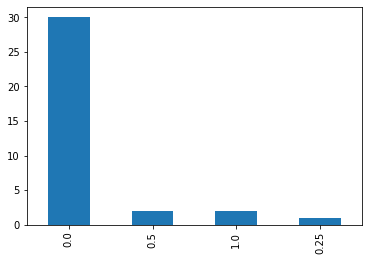

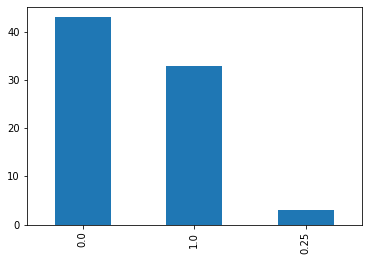

In [47]:
i = "WCSurvived"
for df in [miss, correct]:
    df[i].value_counts().plot(kind="bar")
    plt.show()

In [48]:
data

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,SmallFamily,LargeFamily,Deck,Surname,Ticket_id,Group_id,Title,WC_count,WCSurvived,Predict,Ticket_freq,Pfare,xgb,lgb,cat,lr,rfc
0,1,1.0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,NaN,S,2,1,0,N,Braund,3-A/5 2117-7.25-S,noGroup,man,NaN,NaN,1.0,1,7.250000,1.0,1.0,1.0,1.0,1.0
1,2,0.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C,2,1,0,C,Cumings,1-PC 1759-71.2833-C,noGroup,woman,1.0,NaN,0.0,2,35.641650,0.0,1.0,0.0,0.0,0.0
2,3,0.0,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,N,Heikkinen,3-STON/O2. 310128-7.925-S,noGroup,woman,1.0,NaN,0.0,1,7.925000,0.0,1.0,0.0,0.0,0.0
3,4,0.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S,2,1,0,C,Futrelle,1-11380-53.1-S,noGroup,woman,1.0,NaN,0.0,2,26.550000,0.0,1.0,0.0,0.0,0.0
4,5,1.0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S,1,0,0,N,Allen,3-37345-8.05-S,noGroup,man,NaN,NaN,1.0,1,8.050000,1.0,1.0,1.0,1.0,1.0
5,6,1.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,0,0,N,Moran,3-33087-8.4583-Q,noGroup,man,NaN,NaN,1.0,1,8.458300,1.0,1.0,1.0,1.0,1.0
6,7,1.0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.8625,E46,S,1,0,0,E,McCarthy,1-1746-51.8625-S,noGroup,man,NaN,NaN,1.0,2,25.931250,0.0,1.0,1.0,1.0,1.0
7,8,1.0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S,5,0,1,N,Palsson,3-34990-21.075-S,Palsson-3-34990-21.075-S,boy,5.0,1.00,1.0,5,4.215000,1.0,1.0,1.0,1.0,1.0
8,9,0.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.1333,NaN,S,3,1,0,N,Johnson,3-34774-11.1333-S,Johnson-3-34774-11.1333-S,woman,3.0,0.00,NaN,3,3.711100,NaN,NaN,NaN,NaN,NaN
9,10,0.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,NaN,C,2,1,0,N,Nasser,2-23773-30.0708-C,noGroup,woman,1.0,NaN,0.0,2,15.035400,0.0,1.0,0.0,0.0,0.0
